# Introduction

**see V56 for the best result of LB632 -- Finally I beat the current best public kernel using Keras :) -- This probably be my last update on this kernel -- If you find this kernel helpful, please upvote**

**Version upto V60 have a silly bug of 'if <-- elif' so that model selection is wrong **

This is my effort to do a `Keras` replication with comparable baseline to the great kernel of @mhiro2 https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch (and further improved by @peining), which in turns use the excellent pre-processed data of @daisukelab https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data) -- Note that to inference to the private data in stage-2, you have to preprocess data yourself.

One change I made in a Keras version, in addition to a simple conv net, we can also use a pre-defined architectures [trained from scratch] `MobileNetV2`, `InceptionV3` and `Xception` where you can choose in the kernel. Also, many ideas borrow from a nice kernel of @voglinio https://www.kaggle.com/voglinio/keras-2d-model-5-fold-log-specgram-curated-only , I also borrow the SoftMax+BCE loss & TTA ideas from Giba's kernel (BTW, we all know Giba without having to mention his user :).

I apologize that my code is not at all clean; some of the `pytorch` code is still here albeit not used.

## Major Updates
* V1 [CV680, LB574]
* V4 [CV66x, LB576]
* V5 [] Add image augmentation module
* V9 [CV679] Add lwlrap TF metric (credit @rio114 : https://www.kaggle.com/rio114/keras-cnn-with-lwlrap-evaluation )
* V11 [] Employ list of augmentations mentioned in https://github.com/sainathadapa/kaggle-freesound-audio-tagging/blob/master/approaches_all.md
* V16 [] Add BCEwithLogits (use only with ACTIVATION = 'linear')
* V17 add SimpleCNN similar to the pytorch baseline
* V22 add Curated-Only, Train-augment options
* V23 add CRNN model
* **V30 LB598 with shallow CNN in 400s, set iteration to 150**
* **V39 LB608 with CoarseDropout Augmentation**
* V40 Simple Snapshot (Checkpoint) Ensemble
* **V52 [CV811, LB616] MixUp+CoarseDropout : credit https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up **
* **V56 [CV830, LB632] Change Architecture to get the best result **
* V61 fix silly bugs on model selection


In [1]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count
import matplotlib.pyplot as plt

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

### utils

In [2]:
NUM_CLASSES = 80
SIZE=128
checkpoint_file = ['model_best1.h5', 'model_best2.h5', 'model_best3.h5']
# See Version40 for 3 snapshots (or you can use only 1 which is normal run)
EPOCHS = [432, 0, 0] #150 for inception, 100 for xception
TTA = [19, 0, 0] #Number of test-time augmentation
BATCH_SIZE = 32

LR = 4e-4
PATIENCE = 10 #ReduceOnPlateau option
LR_FACTOR = 0.8 #ReduceOnPlateau option
CURATED_ONLY = True # use only curated data for training
TRAIN_AUGMENT = True # use augmentation for training data?
VALID_AUGMENT = False
MODEL = 'mobile' #'cnn8th' # choose among 'xception', 'inception', 'mobile', 'crnn', 'simple'
SEED = 520

USE_MIXUP = True
MIXUP_PROB = 0.275

# No K-Fold implementation yet
# NUM_K_FOLDS = 5 # how many folds (K) you gonna splits
# NUM_MODEL_RUN = 5 # how many models (<= K) you gonna train [e.g. set to 1 for a simple train/test split]

# if use BCEwithLogits loss, use Activation = 'linear' only
ACTIVATION = 'linear' 
# ACTIVATION = 'softmax'
# ACTIVATION = 'sigmoid'

# LOSS = 'categorical_crossentropy'
# LOSS = 'binary_crossentropy' 
LOSS = 'BCEwithLogits' 

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [4]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [5]:
import tensorflow as tf



# from https://www.kaggle.com/rio114/keras-cnn-with-lwlrap-evaluation/
def tf_one_sample_positive_class_precisions(y_true, y_pred) :
    num_samples, num_classes = y_pred.shape
    
    # find true labels
    pos_class_indices = tf.where(y_true > 0) 
    
    # put rank on each element
    retrieved_classes = tf.nn.top_k(y_pred, k=num_classes).indices
    sample_range = tf.zeros(shape=tf.shape(tf.transpose(y_pred)), dtype=tf.int32)
    sample_range = tf.add(sample_range, tf.range(tf.shape(y_pred)[0], delta=1))
    sample_range = tf.transpose(sample_range)
    sample_range = tf.reshape(sample_range, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_classes = tf.reshape(retrieved_classes, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_class_map = tf.concat((sample_range, retrieved_classes), axis=0)
    retrieved_class_map = tf.transpose(retrieved_class_map)
    retrieved_class_map = tf.reshape(retrieved_class_map, (tf.shape(y_pred)[0], num_classes, 2))
    
    class_range = tf.zeros(shape=tf.shape(y_pred), dtype=tf.int32)
    class_range = tf.add(class_range, tf.range(num_classes, delta=1))
    
    class_rankings = tf.scatter_nd(retrieved_class_map,
                                          class_range,
                                          tf.shape(y_pred))
    
    #pick_up ranks
    num_correct_until_correct = tf.gather_nd(class_rankings, pos_class_indices)

    # add one for division for "presicion_at_hits"
    num_correct_until_correct_one = tf.add(num_correct_until_correct, 1) 
    num_correct_until_correct_one = tf.cast(num_correct_until_correct_one, tf.float32)
    
    # generate tensor [num_sample, predict_rank], 
    # top-N predicted elements have flag, N is the number of positive for each sample.
    sample_label = pos_class_indices[:, 0]   
    sample_label = tf.reshape(sample_label, (-1, 1))
    sample_label = tf.cast(sample_label, tf.int32)
    
    num_correct_until_correct = tf.reshape(num_correct_until_correct, (-1, 1))
    retrieved_class_true_position = tf.concat((sample_label, 
                                               num_correct_until_correct), axis=1)
    retrieved_pos = tf.ones(shape=tf.shape(retrieved_class_true_position)[0], dtype=tf.int32)
    retrieved_class_true = tf.scatter_nd(retrieved_class_true_position, 
                                         retrieved_pos, 
                                         tf.shape(y_pred))
    # cumulate predict_rank
    retrieved_cumulative_hits = tf.cumsum(retrieved_class_true, axis=1)

    # find positive position
    pos_ret_indices = tf.where(retrieved_class_true > 0)

    # find cumulative hits
    correct_rank = tf.gather_nd(retrieved_cumulative_hits, pos_ret_indices)  
    correct_rank = tf.cast(correct_rank, tf.float32)

    # compute presicion
    precision_at_hits = tf.truediv(correct_rank, num_correct_until_correct_one)

    return pos_class_indices, precision_at_hits

def tf_lwlrap(y_true, y_pred):
    num_samples, num_classes = y_pred.shape
    pos_class_indices, precision_at_hits = (tf_one_sample_positive_class_precisions(y_true, y_pred))
    pos_flgs = tf.cast(y_true > 0, tf.int32)
    labels_per_class = tf.reduce_sum(pos_flgs, axis=0)
    weight_per_class = tf.truediv(tf.cast(labels_per_class, tf.float32),
                                  tf.cast(tf.reduce_sum(labels_per_class), tf.float32))
    sum_precisions_by_classes = tf.zeros(shape=(num_classes), dtype=tf.float32)  
    class_label = pos_class_indices[:,1]
    sum_precisions_by_classes = tf.unsorted_segment_sum(precision_at_hits,
                                                        class_label,
                                                       num_classes)
    labels_per_class = tf.cast(labels_per_class, tf.float32)
    labels_per_class = tf.add(labels_per_class, 1e-7)
    per_class_lwlrap = tf.truediv(sum_precisions_by_classes,
                                  tf.cast(labels_per_class, tf.float32))
    out = tf.cast(tf.tensordot(per_class_lwlrap, weight_per_class, axes=1), dtype=tf.float32)
    return out

In [6]:
from keras import backend as k
def BCEwithLogits(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=True), axis=-1)

Using TensorFlow backend.


### dataset

In [7]:
dataset_dir = Path('../input/freesound-audio-tagging-2019')
preprocessed_dir = Path('../input/fat2019_prep_mels1')

In [8]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    #'train_noisy': dataset_dir / 'train_noisy.csv',
    'train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_trn_noisy_best50s.pkl',
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [9]:
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
if CURATED_ONLY:
    train_df = train_curated
else:
    train_df = pd.concat([train_curated, train_noisy], sort=True, ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [10]:
test_df = pd.read_csv(csvs['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
labels = test_df.columns[1:].tolist()
labels[:10]

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation']

In [12]:
num_classes = len(labels)
num_classes

80

In [13]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(4970, 80)

In [14]:
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    if CURATED_ONLY == False:
        x_train.extend(pickle.load(noisy))

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

(4970, 1120)

In [15]:

for ii in range(5):
    print(x_train[ii].shape) #x_train is of shape (TRAIN_NUM,128,LEN,3) [4D Tensor]
    print(x_test[ii].shape,'\n')  #x_test of shape (TEST_NUM,128,LEN,3) [4D Tensor]

(128, 448, 3)
(128, 128, 3) 

(128, 131, 3)
(128, 1021, 3) 

(128, 128, 3)
(128, 300, 3) 

(128, 1623, 3)
(128, 1146, 3) 

(128, 128, 3)
(128, 1442, 3) 



### model

In [16]:
from keras.layers import *
from keras.models import Sequential, load_model, Model
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_xception

from keras.utils import Sequence
from sklearn.utils import shuffle
def create_model_inception(n_out=NUM_CLASSES):

    base_model =InceptionV3(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [17]:
def create_model_xception(n_out=NUM_CLASSES):

    base_model = Xception(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [18]:
def create_model_mobile(n_out=NUM_CLASSES):

    base_model =MobileNetV2(weights=None, include_top=False)
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)

    
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [19]:
def conv_simple_block(x, n_filters):
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)

    return x

def create_model_simplecnn(n_out=NUM_CLASSES):
    
    inp = Input(shape=(128,128,3))
#     inp = Input(shape=(None,None,3))
    x = conv_simple_block(inp,64)
    x = conv_simple_block(x,128)
    x = conv_simple_block(x,256)
    x = conv_simple_block(x,128)
    
#     x1 = GlobalAveragePooling2D()(x)
#     x2 = GlobalMaxPooling2D()(x)
#     x = Add()([x1,x2])

    x = Flatten()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='linear')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [20]:
def output_of_lambda(input_shape):
    return (input_shape[0], input_shape[2], input_shape[3])

def my_max(x):
    return K.max(x, axis=1, keepdims=False)

def crnn_simple_block(x, n_filters):
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    return x

def create_model_crnn(n_out=NUM_CLASSES):
    
#     inp = Input(shape=(128,128,3))
    inp = Input(shape=(128,None,3))
    x = crnn_simple_block(inp,64)
    x = crnn_simple_block(x,128)
    x = crnn_simple_block(x,256)
    
    # eliminate the frequency dimension, x = (batch, time, channels)
    x = Lambda(my_max, output_shape=output_of_lambda)(x)
    
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
#     x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='linear')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [21]:
# from the 8th solution in 2018 competition
# https://github.com/sainathadapa/kaggle-freesound-audio-tagging
def create_model_cnn8th(n_out=NUM_CLASSES):
    regu=0
    inp = Input(shape=(128,128,3))

    x = Conv2D(48, 11,  strides=(1,1),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(inp)
    x = BatchNormalization()(x)
    x = Conv2D(48, 11,  strides=(2,3),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=(1,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, 5, strides=(1,1),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 5, strides=(2,3),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=(1,2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [22]:
K.clear_session()
'''Choose your model here'''
if MODEL == 'xception':
    preprocess_input = preprocess_xception
    model = create_model_xception(n_out=NUM_CLASSES)
elif MODEL == 'inception':
    preprocess_input = preprocess_inception
    model = create_model_inception(n_out=NUM_CLASSES)
elif MODEL == 'mobile':
    preprocess_input = preprocess_mobile
    model = create_model_mobile(n_out=NUM_CLASSES)
elif MODEL == 'crnn':
    preprocess_input = preprocess_mobile
    model = create_model_crnn(n_out=NUM_CLASSES)
elif MODEL == 'cnn8th':
    preprocess_input = preprocess_mobile
    model = create_model_cnn8th(n_out=NUM_CLASSES)
else:
    preprocess_input = preprocess_mobile
    model = create_model_simplecnn(n_out=NUM_CLASSES)

print(MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
mobile
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (Batc

### train

In [23]:
import numpy as np
xx = np.random.rand(1)
print(xx.shape,xx)

xx = np.random.rand(1,1)
print(xx.shape)

(1,) [0.70582626]
(1, 1)


In [24]:
# If you want, you can try more advanced augmentation like this
augment_img = iaa.Sequential([
#         iaa.ContrastNormalization((0.9, 1.1)),
#         iaa.Multiply((0.9, 1.1), per_channel=0.2),
        iaa.Fliplr(0.5),
#         iaa.GaussianBlur(sigma=(0, 0.1)),
#         iaa.Affine( # x-shift
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.0, 0.0)},
#         ),
        iaa.CoarseDropout(0.12,size_percent=0.05) # see examples : https://github.com/aleju/imgaug
            ], random_order=True)



# Or you can choose this simplest augmentation (like pytorch version)
# augment_img = iaa.Fliplr(0.5)

# This is my ugly modification; sorry about that
class FATTrainDataset(Sequence):

    def mix_up(x, y):
        x = np.array(x, np.float32)
        lam = np.random.beta(1.0, 1.0)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y
    
    def getitem(image):
        # crop 2sec

        base_dim, time_dim, _ = image.shape
        crop = random.randint(0, time_dim - base_dim)
        image = image[:,crop:crop+base_dim,:]

        image = preprocess_input(image)
        
#         label = self.labels[idx]
        return image
    def create_generator(train_X, train_y, batch_size, shape, augument=False, shuffling=False, test_data=False, mixup=False, mixup_prob=0.3):
        assert shape[2] == 3
        while True:
            if shuffling:
                train_X,train_y = shuffle(train_X,train_y)

            for start in range(0, len(train_y), batch_size):
                end = min(start + batch_size, len(train_y))
                batch_images = []
                X_train_batch = train_X[start:end]
                if test_data == False:
                    batch_labels = train_y[start:end]
                
                for i in range(len(X_train_batch)):
                    image = FATTrainDataset.getitem(X_train_batch[i])   
                    if augument:
                        image = FATTrainDataset.augment(image)
                    batch_images.append(image)
                
                if (mixup and test_data == False):
                    dice = np.random.rand(1)
                    if dice > mixup_prob:
                        batch_images, batch_labels =  FATTrainDataset.mix_up(batch_images, batch_labels)    
                    
                if test_data == False:
                    yield np.array(batch_images, np.float32), batch_labels
                else:
                    yield np.array(batch_images, np.float32)
        return image
    
    def augment(image):

        image_aug = augment_img.augment_image(image)
        return image_aug

In [25]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split,KFold


reduceLROnPlat = ReduceLROnPlateau(monitor='val_tf_lwlrap', factor=LR_FACTOR, patience=PATIENCE, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-5 )

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

checkpoint = ModelCheckpoint(checkpoint_file[0], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

In [26]:
# split data into train, valid
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

# create train and valid datagens
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=TRAIN_AUGMENT, shuffling=True, mixup = USE_MIXUP, mixup_prob = MIXUP_PROB)
validation_generator = FATTrainDataset.create_generator(
    x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=VALID_AUGMENT, shuffling=False)



In [27]:

train_steps = np.ceil(float(len(x_trn)) / float(BATCH_SIZE))
val_steps = np.ceil(float(len(x_val)) / float(BATCH_SIZE))
train_steps = train_steps.astype(int)
val_steps = val_steps.astype(int)
print(train_steps, val_steps)
print(len(x_trn))


125 32
3976


In [28]:
print(LOSS)
if LOSS=='BCEwithLogits':
     model.compile(loss=BCEwithLogits,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])
else:
    model.compile(loss=LOSS,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])


BCEwithLogits


In [29]:

print(LR, PATIENCE, LR_FACTOR,BATCH_SIZE, TRAIN_AUGMENT, USE_MIXUP, MIXUP_PROB)

0.0004 10 0.8 32 True True 0.275


In [30]:


hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[0],
    verbose=1,
    callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/432
125/125 [==============================] - 30s 238ms/step - loss: 0.8264 - tf_lwlrap: 0.0999 - categorical_accuracy: 0.0133 - val_loss: 0.6638 - val_tf_lwlrap: 0.0758 - val_categorical_accuracy: 0.0141

Epoch 00001: val_tf_lwlrap improved from -inf to 0.07578, saving model to model_best1.h5
Epoch 2/432
125/125 [==============================] - 16s 129ms/step - loss: 0.6238 - tf_lwlrap: 0.0978 - categorical_accuracy: 0.0090 - val_loss: 0.4021 - val_tf_lwlrap: 0.0717 - val_categorical_accuracy: 0.0221

Epoch 00002: val_tf_lwlrap did not improve from 0.07578
Epoch 3/432
125/125 [==============================] - 16s 129ms/step - loss: 0.3651 - tf_lwlrap: 0.0926 - categorical_accuracy: 0.0103 - val_loss: 0.1388 - val_tf_lwlrap: 0.0615 - val_categorical_accuracy: 0.0080

Epoch 00003: val_tf_lwlrap did not improve from 0.07578
Epoch 4/432
125/125 [=======

In [31]:
print(K.eval(model.optimizer.lr))

1e-05


In [32]:
# if LOSS=='BCEwithLogits':
#      model.compile(loss=BCEwithLogits,
#             optimizer=Adam(lr=3e-4),
#             metrics=[tf_lwlrap,'categorical_accuracy'])
# else:
#     model.compile(loss=LOSS,
#             optimizer=Adam(lr=3e-4),
#             metrics=[tf_lwlrap,'categorical_accuracy'])

# train_generator = FATTrainDataset.create_generator(
#     x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=TRAIN_AUGMENT, 
#     shuffling=True, mixup = False, mixup_prob=0.1)

# EPOCHS = [100, 66, 0]

# print(K.eval(model.optimizer.lr))

In [33]:
if EPOCHS[1] > 0:
    checkpoint = ModelCheckpoint(checkpoint_file[1], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]
    
    hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[1],
    verbose=1,
    callbacks=callbacks_list)

In [34]:
print(K.eval(model.optimizer.lr))

1e-05


In [35]:
if EPOCHS[2] > 0:
    checkpoint = ModelCheckpoint(checkpoint_file[2], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]
    
    hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[2],
    verbose=1,
    callbacks=callbacks_list)

In [36]:
print(K.eval(model.optimizer.lr))

1e-05


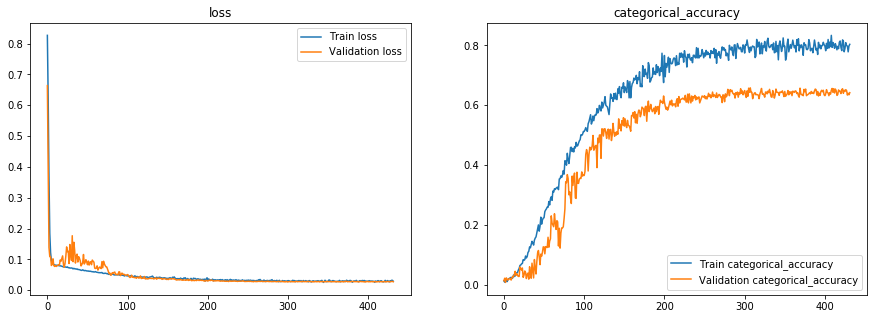

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

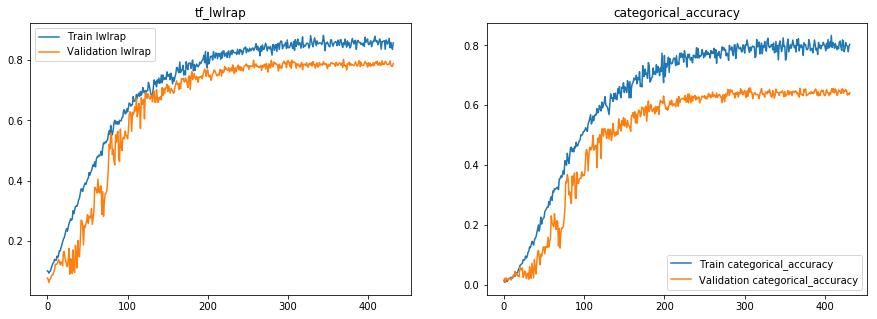

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('tf_lwlrap')
ax[0].plot(hist.epoch, hist.history["tf_lwlrap"], label="Train lwlrap")
ax[0].plot(hist.epoch, hist.history["val_tf_lwlrap"], label="Validation lwlrap")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

# Calculate Validation Score using TTA
Note that we have to initiate validation_generation everytime before doing a new prediction as `model.fit_generator` will mis-index examples at the end of epoch (and you will get random score)

In [39]:
model.load_weights(checkpoint_file[0])

validation_generator = FATTrainDataset.create_generator(
      x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
pred_val_y = model.predict_generator(validation_generator,steps=val_steps,verbose=1)

for kk in range(len(TTA)):
    
    for ii in range(TTA[kk]):
        validation_generator = FATTrainDataset.create_generator(
          x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
        
        pred_val_y += model.predict_generator(validation_generator,steps=val_steps,verbose=1)
    
    if kk+1 < len(TTA) and TTA[kk+1] > 0:
        model.load_weights(checkpoint_file[kk+1])

'''Since the score is based on ranking, we do not need to normalize the prediction'''
# pred_val_y = pred_val_y/10


32/32 [==============================] - 1s 16ms/step


'Since the score is based on ranking, we do not need to normalize the prediction'

In [40]:
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
pred_train_y = model.predict_generator(train_generator,steps=train_steps,verbose=1)

125/125 [==============================] - 2s 15ms/step


In [41]:
import sklearn.metrics
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

In [42]:
print(pred_val_y.shape, y_val.shape)
print(np.sum(pred_val_y), np.sum(y_val))
# for ii in range(len(y_val)):
#     print(np.sum(pred_val_y[ii]), np.sum(y_val[ii]))

(994, 80) (994, 80)
-11160808.0 1128


In [43]:
print("lwlrap from sklearn.metrics for training data =", calculate_overall_lwlrap_sklearn(y_trn, pred_train_y))
print("val lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(y_val, pred_val_y/10))

score, weight = calculate_per_class_lwlrap(y_val, pred_val_y)
lwlrap = (score * weight).sum()
print('direct calculation of val lwlrap : %.4f' % (lwlrap))

lwlrap from sklearn.metrics for training data = 0.9937980679367769
val lwlrap from sklearn.metrics = 0.7947953814827754
direct calculation of val lwlrap : 0.7948


### Simple Error Analysis

In [44]:
idx = np.sum(y_val,axis=1) > 1
print(y_val[idx, :].shape, y_val[idx==False, :].shape)

print("val lwlrap for multi-labels =", calculate_overall_lwlrap_sklearn(y_val[idx], pred_val_y[idx]))
print("val lwlrap for single-label =", calculate_overall_lwlrap_sklearn(y_val[idx==False], pred_val_y[idx==False]))

(125, 80) (869, 80)
val lwlrap for multi-labels = 0.7788500531195031
val lwlrap for single-label = 0.7995477865991014


## Predict Test Data with TTA

In [45]:
test_steps = np.ceil(float(len(x_test)) / float(BATCH_SIZE)).astype(int)


In [46]:
model.load_weights(checkpoint_file[0])

test_generator = FATTrainDataset.create_generator(
    x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
pred_test_y = model.predict_generator(test_generator,steps=test_steps,verbose=1)

for kk in range(len(TTA)):
    for ii in range(TTA[kk]):
        test_generator = FATTrainDataset.create_generator(
        x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
        
        pred_test_y += model.predict_generator(test_generator,steps=test_steps,verbose=1)
    
    if kk+1 < len(TTA) and TTA[kk+1] > 0:
        model.load_weights(checkpoint_file[kk+1])

35/35 [==============================] - 1s 15ms/step


In [47]:
 sort_idx = np.argsort(labels).astype(int)


In [48]:
print(sort_idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


In [49]:
sample_sub = pd.read_csv('../input/freesound-audio-tagging-2019/sample_submission.csv')
test_Y_sort = pred_test_y[:, sort_idx]
sample_sub.iloc[:, 1:] =  test_Y_sort
sample_sub.to_csv('submission.csv', index=False)

sample_sub.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,-154.853333,-178.622345,-137.645279,-154.654419,-124.198723,-90.385544,-142.185196,-137.812469,-138.565384,-153.399643,-201.863922,-112.590446,-167.950424,-152.431244,-123.539162,-174.791885,-131.379517,-112.975777,-102.205811,-128.255188,-143.962601,-94.680016,-103.982864,-155.999771,-170.701401,-132.749313,-158.423187,-129.067734,-88.132072,-152.102936,-114.950851,-177.695953,-165.111359,-161.450089,-65.654366,-123.604744,-173.658646,-110.371590,-118.552368,...,-136.657730,-80.833687,-76.008614,-52.389675,-112.380257,-179.925827,-168.754074,-137.669662,-155.997314,-143.984802,-146.675232,-181.179291,-152.163971,-140.362534,-173.362320,-105.249641,-140.448929,-21.607168,-134.787094,-120.870018,-168.424088,-124.784126,-170.310379,-129.334290,-125.054817,-185.195908,-198.096848,-125.812569,-153.101074,-117.250816,-146.107193,-170.613693,-173.522430,-155.921005,-115.733025,-145.422348,-151.045929,-128.553894,-156.360153,-122.739861
1,0012633b.wav,-62.905537,-155.926025,-138.813126,-119.286285,-128.623001,-107.421608,-117.954216,-103.484245,-151.647125,-126.284729,-78.873962,-94.407585,-93.573647,-127.269173,-114.862892,-113.028473,-160.390396,-134.240265,-122.413582,-128.304337,-133.172455,-126.067062,-106.052284,-101.589500,-92.002258,-122.982216,-146.447388,-86.519646,-137.728333,-140.953552,-119.300606,-115.604599,-83.867584,-144.961563,-142.727844,-95.805359,-125.504265,-176.897659,-146.918961,...,-136.444107,-101.548592,-65.146385,-126.850113,-131.481491,-133.110703,-97.993729,-169.877930,-87.127296,-124.832420,-113.417046,-52.576317,-119.745071,-109.289818,-101.353928,-140.371384,-104.423149,-118.286674,-122.275467,-106.876328,-99.023911,-115.665268,-144.726486,-113.147545,-105.946510,-115.739090,-103.745323,-143.261154,-134.529968,-125.865173,-95.892647,-99.298775,-165.476944,-87.202202,-123.759155,-110.890076,-119.185394,-115.745705,-110.586319,-81.263016
2,001ed5f1.wav,-101.077438,-147.583435,-141.133286,-120.893265,-146.542221,-67.569916,-158.589569,-139.982452,-148.177200,-144.732056,-138.599991,-159.205124,-110.573296,-119.526703,-145.336166,-144.591415,-173.150818,-167.804047,-131.148315,-110.805908,-91.404381,-113.493416,-128.482849,-104.639275,-51.280102,-156.507355,-145.904129,-110.458534,-143.541916,-100.457184,-142.308945,-147.852600,-148.411362,-146.490112,-148.189041,-145.663513,-159.535049,-154.560776,-128.125549,...,-132.193253,-119.543129,-114.511192,-151.329010,-74.890625,-135.468109,-114.729401,-134.144623,-83.362862,-146.885223,-79.176186,-128.968140,-63.887157,-125.443436,-110.636795,-148.850845,-70.395470,-105.381134,-154.585526,-166.385941,-128.774918,-134.997665,-126.406754,-76.985252,-123.166809,-126.575348,-124.839615,-135.824097,-80.331917,-101.222527,-109.322578,-108.276291,-205.554184,-88.256729,-129.910019,-111.753059,-126.301758,-140.626678,-126.691399,-128.583664
3,00294be0.wav,-173.398453,-147.612381,-148.860428,-205.831070,-